### Logistic regression

I will go through the whole process of creating a machine learning model on the famous Titanic dataset, which is used by many people all over the world. It provides information on the fate of passengers on the Titanic, summarized according to economic status (class), sex, age and survival.

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

Getting the Data

In [2]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

Data Exploration/Analysis

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Above we can see that 38% out of the training-set survived the Titanic. We can also see that the passenger ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values, like the ‘Age’ feature.

In [5]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


Let’s take a more detailed look at what data is actually missing:

In [6]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [7]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

### Data Preprocessing

First, I will drop ‘PassengerId’ from the train set, because it does not contribute to a persons survival probability. I will not drop it from the test set, since it is required there for the submission.

In [8]:
train_df = train_df.drop(['PassengerId'], axis=1)

In [9]:
# extracting and then removing the targets from the training data 
targets = train_df['Survived']
train_df.drop(['Survived'], 1, inplace=True)

In [10]:
# merging train data and test data for future feature engineering
# we'll also remove the PassengerID since this is not an informative feature
combined = train_df.append(test_df)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

In [11]:
#Now let's map the title can bin them
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [12]:
#Generate a new Title column
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined['Title'] = combined['Title'].map(Title_Dictionary)

In [13]:
#let's get the median age based on people's gender, Pclass and Title
fill_mean = lambda g: g.fillna(g.mean())
combined['Age'] = combined.groupby(['Sex', 'Title', 'Pclass'])['Age'].apply(fill_mean)

In [14]:
# Name can be dropped now
combined.drop('Name', axis=1, inplace=True)

In [15]:
# removing the title variable
combined.drop('Title', axis=1, inplace=True)

In [16]:
# removing the Cabin variable
combined.drop('Cabin', axis=1, inplace=True)

In [17]:
# removing the Ticket variable
combined.drop('Ticket', axis=1, inplace=True)

In [18]:
#Fill out the missing fare data
combined['Fare'].fillna(combined['Fare'].mean(), inplace=True)

In [19]:
# two missing embarked values - filling them with the most frequent one in the train set
combined['Embarked'].fillna('S', inplace=True)

In [20]:
# encoding in dummy variable
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop('Embarked', axis=1, inplace=True)

In [21]:
# mapping gender to numerical one 
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})

In [22]:
# introducing a new feature : the size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

### Random Forest and K-fold Validation

In [23]:
# Prepare the training dataset
df_im_input=combined.iloc[:891]
df_im_output=targets

In [38]:
# ref. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# create a random hyperparameter grid

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 2000, num = 13)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [80,
  240,
  400,
  560,
  720,
  880,
  1040,
  1200,
  1360,
  1520,
  1680,
  1840,
  2000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [39]:
# search the best parameters

from sklearn.ensemble import RandomForestRegressor

# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 6 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 6, verbose=2, random_state=2345, n_jobs = -1)
# Fit the random search model
rf_random.fit(df_im_input, df_im_output)

rf_random.best_params_


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.5min finished


{'n_estimators': 1040,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [40]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(max_depth=80, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=1040)

In [47]:
# use the best_random parameters to train the whole dataset
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=80, min_samples_leaf=4, min_samples_split=10, n_estimators=1040, random_state = 2345)
rf.fit(df_im_input, df_im_output)

RandomForestClassifier(max_depth=80, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1040, random_state=2345)

In [49]:
# evaluation

preds=rf.predict(df_im_input)
preds_probabilities = rf.predict_proba(df_im_input)
pred_probs = preds_probabilities[:, 1]

In [51]:
from sklearn.metrics import roc_curve, auc
#roc_curve() returns a list of false positive rates (FPR) and true positives rates (TPR) for different configurations of the classifier used to plot the ROC.
[fpr, tpr, thr] = roc_curve(targets, pred_probs)

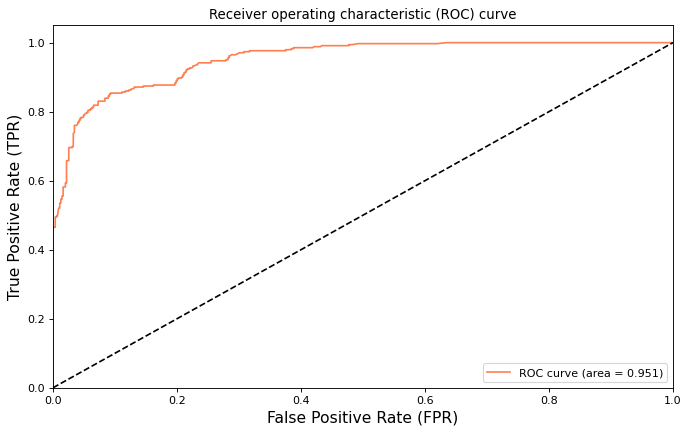

In [52]:
#plot ROC curve
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [53]:
#check model accuracy on training dataset
from sklearn.metrics import confusion_matrix, accuracy_score
print("accuracy: %2.3f" % accuracy_score(targets, preds))
print("AUC: %2.3f" % auc(fpr, tpr))

accuracy: 0.889
AUC: 0.951


In [55]:
# #confusion matrix can give us the number of true positives, false positives, true negatives, and false negatives.
conf_m=confusion_matrix(targets, preds)
conf_m

array([[522,  27],
       [ 72, 270]])